# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing

#### (1) Read file 

In [2]:
df = pd.read_csv('data/Pork Bill - LY.csv',encoding='utf-8')
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])
data = df[['text', 'pork_bill']]

In [3]:
data.head(10)

,text,pork_bill
0,軍人撫卹條例第十八條條文修正草案落實軍人及眷屬之照顧（撫卹金）,1
1,所得稅法第十七條條文修正草案學費之特別扣除額應以每人所繳之學雜費為限,1
2,所得稅法第十一條條文修正草案保險人員申報時得扣除一定比例之業務必要費用,1
3,土地稅法第二十八條之一條文修正草案土地贈與文教基金會未能免爭土地增值稅，修正之,1
4,敬老福利生活津貼暫行條例第三條條文修正草案放寬請領資格之門檻,1
5,洗錢防制法部分條文修正草案給予法官較大權限；起訴期間禁止被告的高消費行為,0
6,日據時代日本政府國庫券及債券處理條例草案就是保障日據時代持有日本債券者,0
7,大陸地區人民來臺從事觀光活動條例草案開放大陸人民觀光，振興經濟,0
8,限制欠稅人或欠稅營利事業負責人出境實施條例草案現行法令僅為行政命令位階,0
9,使用牌照稅法第七條條文修正草案民營汽車駕駛人訓練機構之教練車亦應免徵使用牌照稅,1


In [4]:
print(" Pork Legislation", data['pork_bill'].value_counts()[0],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[1])

 Pork Legislation 792 
 None-Pork Legislation 399


#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # 首先分割 英文 以及英文和标点
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # 分割中文
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

# import spacy
# # python3 -m spacy download zh_core_web_sm
# spacy_nlp = spacy.load("zh_core_web_sm")

# data_clean = [clearPucts(text) for text in data.text]
# data_clean = [[spacy_nlp(sentence).vector for sentence in data] for data in data_clean]

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/Testing Set

In [8]:
data_labels = data.pork_bill.values

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of x Test: ", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of y Test: ", test_labels.shape )

Shape of X Train: (797, 123) 
Shape of x Test:  (394, 123) 
Shape of Y Trian: (797,) 
Shape of y Test:  (394,)


-------------------------


### Stage 3: Model Specification and Building

#### (1) Build the Model

In [10]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, 
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, 
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output


In [11]:
VOCAB_SIZE = 1819 # tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
NB_EPOCHS = 150

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [12]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (123 , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  363800    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

#### (3) Check Point Path

In [13]:
pwd

'/Users/yenchiehliao/Dropbox/My Mac (Davids-MacBook-Pro.local)/Documents/GitHub/PorkCNN'

In [14]:
checkpoint_path = "ckpt"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

Latest checkpoint restored!!


-------------------------

### Stage 4: Train the Model

In [15]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [16]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/150
25/25 [==============================] - 2s 53ms/step - loss: 0.0041 - accuracy: 0.9975 - val_loss: 0.3596 - val_accuracy: 0.8959
Epoch 2/150
25/25 [==============================] - 1s 51ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 0.3706 - val_accuracy: 0.8985
Epoch 3/150
25/25 [==============================] - 1s 49ms/step - loss: 0.0025 - accuracy: 0.9987 - val_loss: 0.3758 - val_accuracy: 0.8959
Epoch 4/150
25/25 [==============================] - 1s 50ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.3795 - val_accuracy: 0.8959
Epoch 5/150
25/25 [==============================] - 1s 53ms/step - loss: 0.0041 - accuracy: 0.9975 - val_loss: 0.3837 - val_accuracy: 0.8985
Epoch 6/150
25/25 [==============================] - 1s 55ms/step - loss: 0.0026 - accuracy: 0.9987 - val_loss: 0.3873 - val_accuracy: 0.8985


'ckpt/ckpt-3'

-------------------------

### Stage 5: Evaluation

In [17]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.004123,0.997491,0.359636,0.895939
1,0.003545,0.998745,0.370573,0.898477
2,0.002460,0.998745,0.375845,0.895939
3,0.004108,0.998745,0.379514,0.895939
4,0.004116,0.997491,0.383736,0.898477
5,0.002649,0.998745,0.387292,0.898477


<AxesSubplot:>

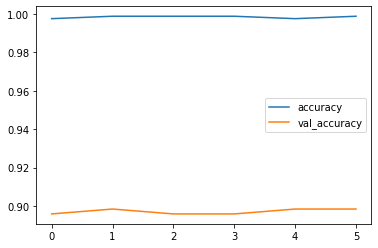

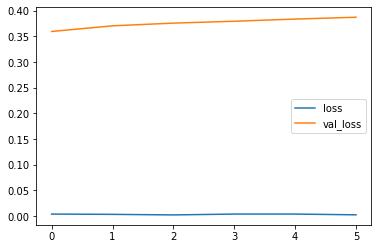

In [18]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [19]:
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

13/13 [==============================] - 0s 8ms/step - loss: 0.3873 - accuracy: 0.8985
[0.3872922360897064, 0.8984771370887756]


In [21]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       265
           1       0.90      0.80      0.84       129

    accuracy                           0.90       394
   macro avg       0.90      0.88      0.89       394
weighted avg       0.90      0.90      0.90       394



In [22]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal:Not Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),253,12
Acutal:Not Pork (1),26,103


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 200 samples from Leislative Questions

In [23]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [24]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/interpellation_ly_6th.csv')

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['title', 'topic']].reset_index(drop=True)

# randomly subsect 200 rows 
random.seed(4)
sample_df = LQ6.loc[random.sample(range(len(LQ6)), 200), ['title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]

##### Top 10 of 200 Sampled Legislative Questions

In [25]:
pd.DataFrame(
    {'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(10)

,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
8671,0.811236739158630,針對政府公教貸款利率高於一般商業銀行專案辦理之房屋貸款利率，使公教人員之房貸利息負擔沈重依舊...,公務員福利 ; 房屋貸款 ; 利率,公教貸款利率
8329,0.443107038736343,南投縣為農業縣份，工商不發達，稅收財源不豐裕，全年度自有財源收入尚不敷支應全縣人事費支出，而...,地方財政,稅收 ; 地方財政
4594,0.312157511711121,針對目前政府十三萬臨時人員已依勞退新制提撥退休金，但仍尚未納入勞基法保障，政府應儘速公布將臨...,勞動基準 ; 聘僱人員 ; 法律適用範圍,臨時人員 ; 勞基法
9150,0.247517079114914,針對近年來財務持續惡化的中央健康保險局，利用健保費給付銀行巨額借款利息表示斥責。健保局用民眾...,國民 ; 健康保險 ; 保險費,財務 ; 中央健康保險局 ; 健保費給付
7062,0.157373845577240,針對交通部修正「道路交通安全規則」，將大客車、聯結車、大貨車等大型車職業司機考照執業年齡上限...,退休年齡,道路交通安全規則 ; 職業司機 ; 退休年齡
7720,0.123674273490906,針對內政部公告「低收入戶之資格家庭總收入以外財產總額之一定限額」有關不動產（土地及房屋）限額...,低收入戶 ; 不動產 ; 政府補助,低收入戶 ; 不動產 ; 低收入戶補助
9810,0.122287094593048,針對外籍新娘及孩童的教育及生活問題，特向行政院提出質詢。,外國人 ; 婚姻 ; 教育,外籍新娘 ; 孩童 ; 教育
5359,0.105992794036865,針對連興街站（汐科園站）北站體增建電動步道案，特向行政院提出質詢。,道路工程,連興街站 ; 電動步道
840,0.084752440452576,針對台北縣板橋市大漢溪沿岸的環河道路，因道路寬窄不一，規劃不完善且無汽、機車分流，加上大型車...,交通安全 ; 道路工程,大漢溪 ; 環河道路
7009,0.078537642955780,針對交通部修正「道路交通安全規則」，將大客車、聯結車、大貨車等大型車職業司機考照執業年齡上限...,退休年齡,道路交通安全規則 ; 職業司機 ; 退休年齡


##### Last 10 Rows of 200 Sampled Legislative Questions

In [30]:
pd.DataFrame(
    {'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(5)

,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
5952,0.000001753699053,針對行政院金融監督管理委員會（金管會）宣稱，台灣上市上櫃公司投資中國累計匯回資金比例達7.9...,大陸政策 ; 對外投資,投資中國 ; 台商資金匯回
5617,0.000001426775611,就立委及總統選舉在即，立委選舉制度首次採行「單一選區兩票制」，選情緊繃，賄影重重，為免賄選猖...,選舉風紀,總統選舉 ; 立委選舉 ; 賄選
4080,0.000001366255105,針對政府若干公務人員涉嫌重大弊案，諸如高雄捷運弊案、股市禿鷹案、國道電子收費（ETC）案，嚴...,公務員 ; 行政中立 ; 黨政關係 ; 政府官員,公務人員 ; 弊案 ; 政務官 ; 行政中立 ; 輔選
1019,0.000001024151629,針對行政院金融監督管理委員會提出「現金卡廣告最新規範」，宣布自五月一日起，現金卡應暫停在電子...,消費貸款 ; 銀行管理,現金卡廣告
1861,0.000001019861088,針對詐騙集團猖獗，行騙手法推陳出新，令人防不勝防，據統計約有八成民眾曾接獲詐騙集團的行騙電話...,電話 ; 詐欺,詐騙集團 ; 電話 ; 簡訊


#### (2) Export an End-to-end Model


In [27]:
from tensorflow.keras.models import load_model

In [ ]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

In [29]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')